## The Battle of the Neighbourhoods - London

# Introduction

London has 33 boroughs (including the City of London) and is home to over 8 million people and an additional 0.5m people commute to jobs there from outside London.

For this project, we want to look at the boroughs of London and classify them. Some neighborhoods are mostly residential, some have more business or commercial spaces surrounding them. The venues closest to the centre of a neighbourhood determine why and how people use it.

By analysing the venues data, we can classify boroughs by their primary usage. This data could be useful for city planners and residents alike: it could help plan further city development, or help individuals where to live or set up a business.

# Data

We'll need data on the location of the boroughs and on the venues closest to them.

1. A list of boroughs is available from Wikipedia and their central location coordinates can be obtained using Nominatim.
2. We can use the Foursquare API to explore venue types in each borough. Foursquare outlines these high-level venue categories with more sub-categories:

    * Arts & Entertainment (4d4b7104d754a06370d81259)
    * College & University (4d4b7105d754a06372d81259)
    * Event (4d4b7105d754a06373d81259)
    * Food (4d4b7105d754a06374d81259)
    * Nightlife Spot (4d4b7105d754a06376d81259)
    * Outdoors & Recreation (4d4b7105d754a06377d81259)
    * Professional & Other Places (4d4b7105d754a06375d81259)
    * Residence (4e67e38e036454776db1fb3a)
    * Shop & Service (4d4b7105d754a06378d81259)
    * Travel & Transport (4d4b7105d754a06379d81259)

We'll be querying the number of venues in each category in a 1000m radius around the centre of each borough. This radius was chosen because 1000m is a reasonable walking distance.

# Notebook

In [2]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import folium
import requests
from tqdm import tqdm
from collections import deque
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

Here I geocode all London boroughs before making a dataframe

In [121]:
lon_bor = [
"Barking and Dagenham"
,"Barnet"
,"Bexley"
,"Brent"
,"Bromley"
,"Camden"
,"City"
,"Croydon"
,"Ealing"
,"Enfield"
,"Greenwich"
,"Hackney"
,"Hammersmith and Fulham"
,"Haringey"
,"Harrow"
,"Havering"
,"Hillingdon"
,"Hounslow"
,"Islington"
,"Kensington and Chelsea"
,"Kingston upon Thames"
,"Lambeth"
,"Lewisham"
#,"London"
,"Merton"
,"Newham"
,"Redbridge"
,"Richmond upon Thames"
,"Southwark"
,"Sutton"
,"Tower Hamlets"
,"Waltham Forest"
,"Wandsworth"
,"Westminster"]

In [122]:
location, latitude, longitude = [], [], []
for london_borough in lon_bor:
    geolocator = Nominatim(user_agent="lon_explorer")
    location = geolocator.geocode(london_borough + ' London, UK')
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    print(f"Completed {london_borough}...")

Completed Barking and Dagenham...
Completed Barnet...
Completed Bexley...
Completed Brent...
Completed Bromley...
Completed Camden...
Completed City...
Completed Croydon...
Completed Ealing...
Completed Enfield...
Completed Greenwich...
Completed Hackney...
Completed Hammersmith and Fulham...
Completed Haringey...
Completed Harrow...
Completed Havering...
Completed Hillingdon...
Completed Hounslow...
Completed Islington...
Completed Kensington and Chelsea...
Completed Kingston upon Thames...
Completed Lambeth...
Completed Lewisham...
Completed Merton...
Completed Newham...
Completed Redbridge...
Completed Richmond upon Thames...
Completed Southwark...
Completed Sutton...
Completed Tower Hamlets...
Completed Waltham Forest...
Completed Wandsworth...
Completed Westminster...


In [123]:
# Bring these lat lons into a dataframe
boroughs = pd.DataFrame(zip(lon_bor, latitude, longitude), columns = ['Borough', 'Latitude', 'Longitude'])
boroughs

,Borough,Latitude,Longitude
0,Barking and Dagenham,51.554117,0.150504
1,Barnet,51.648784,-0.172913
2,Bexley,51.441679,0.150488
3,Brent,51.584778,-0.299180
4,Bromley,51.402805,0.014814
5,Camden,51.542305,-0.139560
6,City,51.515618,-0.091998
7,Croydon,51.371305,-0.101957
8,Ealing,51.512655,-0.305195
9,Enfield,51.652085,-0.081018


Create a map of London with boroughs superimposed

In [124]:
# create map of london using latitude and longitude values
map_london = folium.Map(location=[51.5074, -0.1277], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(boroughs['Latitude'], boroughs['Longitude'], boroughs['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [125]:
boroughs.shape

(33, 3)

# Venues and Categories

We will use Foursquare API to explore venue categories in each borough. Venues can be categorized as residential, professional, shopping or leisure. Let's see what venue categories Foursquare identifies.

In [17]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'AMW1XUWHOJDF5ADOFUJOY0OWQNUNQSYU4FLSISCEJSZJQ0KC' # your Foursquare ID
CLIENT_SECRET = 'ANCHWAVARYCRW2JKQQ4FKIT4ODETVLKDPMHHJMOS3XAPMDTP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: AMW1XUWHOJDF5ADOFUJOY0OWQNUNQSYU4FLSISCEJSZJQ0KC
CLIENT_SECRET:ANCHWAVARYCRW2JKQQ4FKIT4ODETVLKDPMHHJMOS3XAPMDTP


In [18]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [19]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


We can use the foursquare explore API with categoryId to query the number of venues of each category in a specific radius. The response contains a totalResults value for the specified coordinates, radius and category.

In [14]:
def get_venues_count(lat, lng, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                lng,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [205]:
#Create new dataframe to store venues data
london_venues = boroughs.copy()
for c in categories_list:
    london_venues[c[0]] = 0

In [206]:
london_venues.head()

,Borough,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot
0,Barking and Dagenham,51.554117,0.150504,0,0,0,0,0
1,Barnet,51.648784,-0.172913,0,0,0,0,0
2,Bexley,51.441679,0.150488,0,0,0,0,0
3,Brent,51.584778,-0.299180,0,0,0,0,0
4,Bromley,51.402805,0.014814,0,0,0,0,0


In [211]:
#Request number of venues, store result as CSV
for i, row in london_venues.iterrows():
    print(i)
    for c in categories_list:        
        london_venues.loc[i, c[0]] = get_venues_count(london_venues.Latitude.iloc[i], london_venues.Longitude.iloc[i], radius=1000, categoryId=c[1])
    london_venues.to_csv('london_venues.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [4]:
#Read already stored CSV
london_venues = pd.read_csv('london_venues.csv', index_col=0)
london_venues

,Borough,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Barking and Dagenham,51.554117,0.150504,1,5,0,5,4,8,4,1,10,3
1,Barnet,51.648784,-0.172913,2,4,0,8,4,5,13,3,9,4
2,Bexley,51.441679,0.150488,1,1,0,8,6,2,5,0,15,3
3,Brent,51.584778,-0.299180,1,4,0,4,4,5,8,2,5,3
4,Bromley,51.402805,0.014814,7,1,1,44,12,9,28,5,75,12
5,Camden,51.542305,-0.139560,33,12,0,126,75,33,68,7,115,56
6,City,51.515618,-0.091998,40,58,0,217,190,139,150,15,137,115
7,Croydon,51.371305,-0.101957,5,5,1,60,27,9,48,4,93,37
8,Ealing,51.512655,-0.305195,6,11,0,68,25,10,46,5,66,38
9,Enfield,51.652085,-0.081017,3,6,0,23,8,5,13,1,61,5


In [9]:
london_venues_plot1 = london_venues.drop(['Latitude','Longitude'], 1)

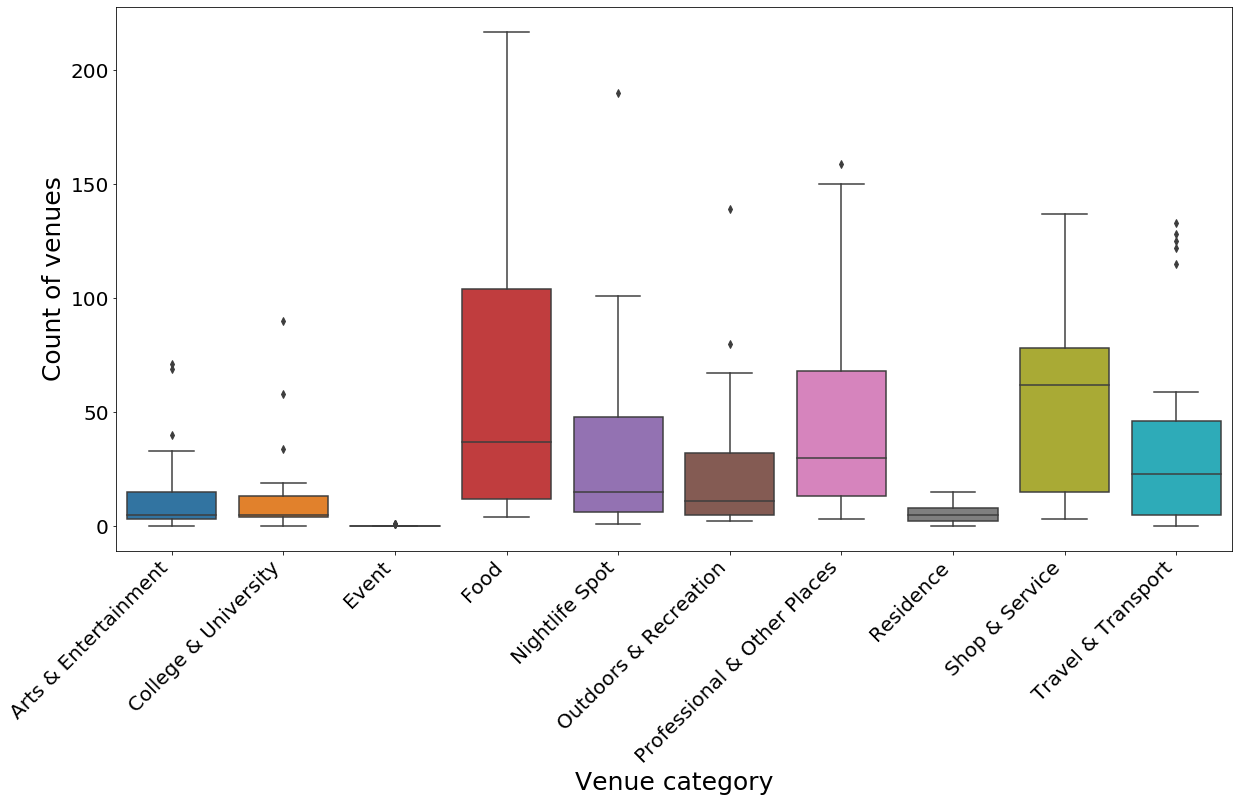

In [10]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = london_venues_plot1)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

The most frequent venue categories are professional, shop&service and food. Event has very little data, let's discard it from both the dataframe and the list of categories.

In [11]:
london_venues_plot2 = london_venues_plot1.drop(['Event'], 1)

In [20]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

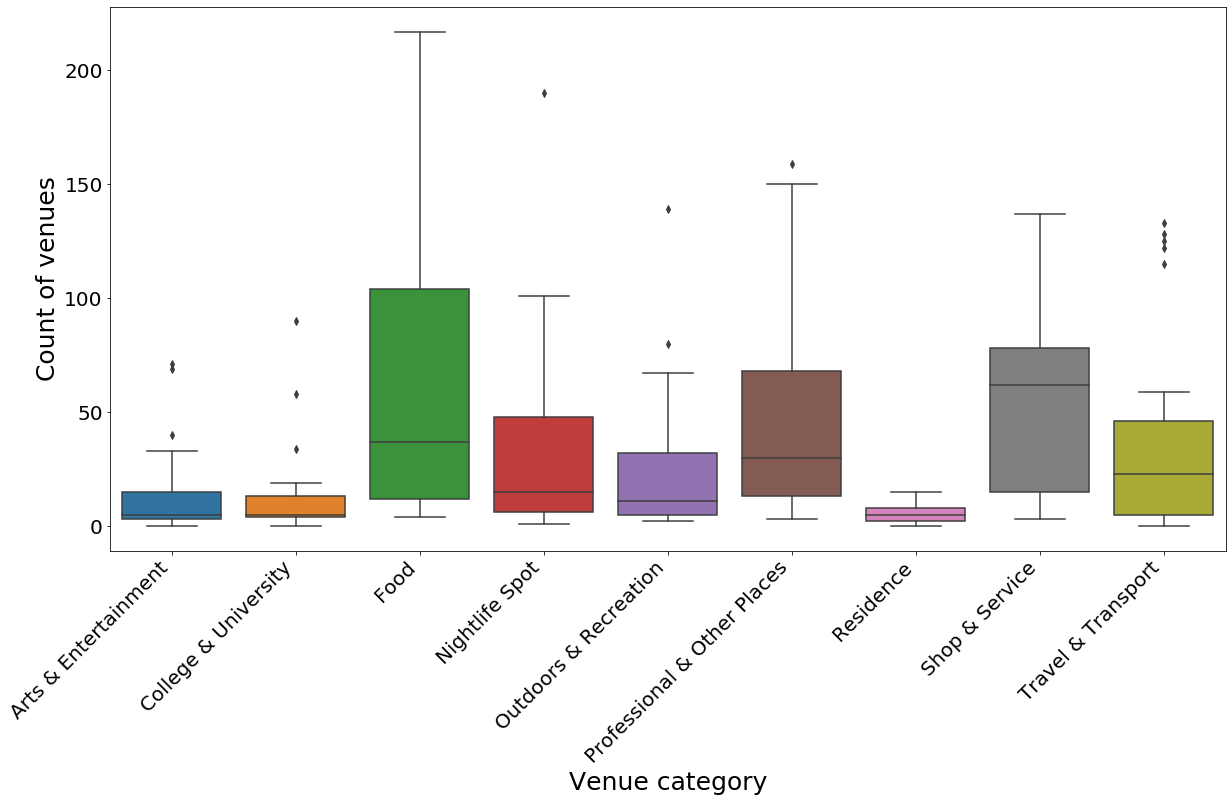

In [43]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = london_venues_plot2)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

# Data Preparation

Let's normalize the data using MinMaxScaler (scale from 0 to 1). This scales the data and provides an easy to interpret score at the same time.

In [22]:
london_venues_plot2.head()

,Borough,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Barking and Dagenham,1,5,5,4,8,4,1,10,3
1,Barnet,2,4,8,4,5,13,3,9,4
2,Bexley,1,1,8,6,2,5,0,15,3
3,Brent,1,4,4,4,5,8,2,5,3
4,Bromley,7,1,44,12,9,28,5,75,12


In [23]:
from sklearn.preprocessing import MinMaxScaler

X = london_venues_plot2.values[:,1:]
cluster_dataset = MinMaxScaler().fit_transform(X)

In [25]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.014085,0.055556,0.004695,0.015873,0.043796,0.006410,0.066667,0.052239,0.022556
1,0.028169,0.044444,0.018779,0.015873,0.021898,0.064103,0.200000,0.044776,0.030075
2,0.014085,0.011111,0.018779,0.026455,0.000000,0.012821,0.000000,0.089552,0.022556
3,0.014085,0.044444,0.000000,0.015873,0.021898,0.032051,0.133333,0.014925,0.022556
4,0.098592,0.011111,0.187793,0.058201,0.051095,0.160256,0.333333,0.537313,0.090226


Visualize the scaled data

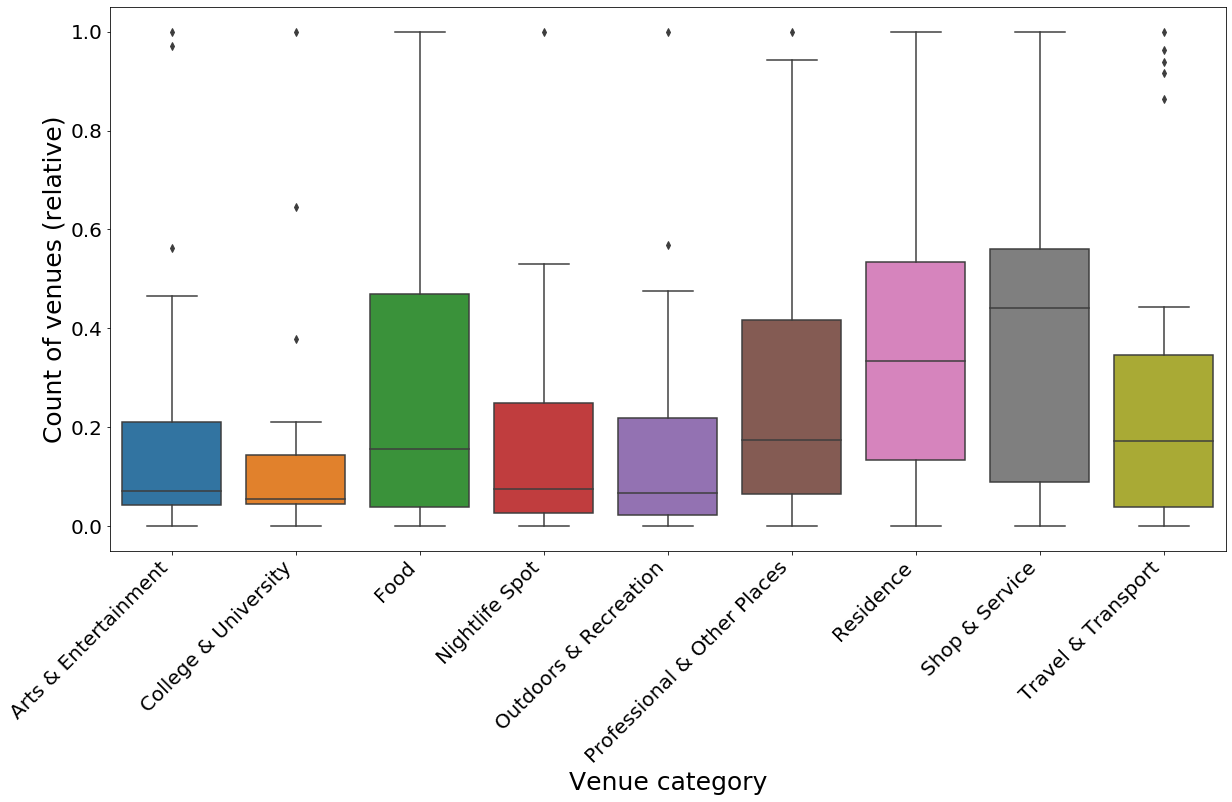

In [26]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

# Clustering
We'll be using k-means clustering.

In [31]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:3, 1:0, 2:1, 3:2}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

london_venues_clusters_df = london_venues.copy()
london_venues_clusters_df['Cluster'] = kmeans_labels
london_venues__clusters_minmax_df = cluster_df.copy()
london_venues__clusters_minmax_df['Cluster'] = kmeans_labels
london_venues__clusters_minmax_df['Borough'] = london_venues['Borough']
london_venues__clusters_minmax_df['Latitude'] = london_venues['Latitude']
london_venues__clusters_minmax_df['Longitude'] = london_venues['Longitude']

Visualize the clusters with boxplots

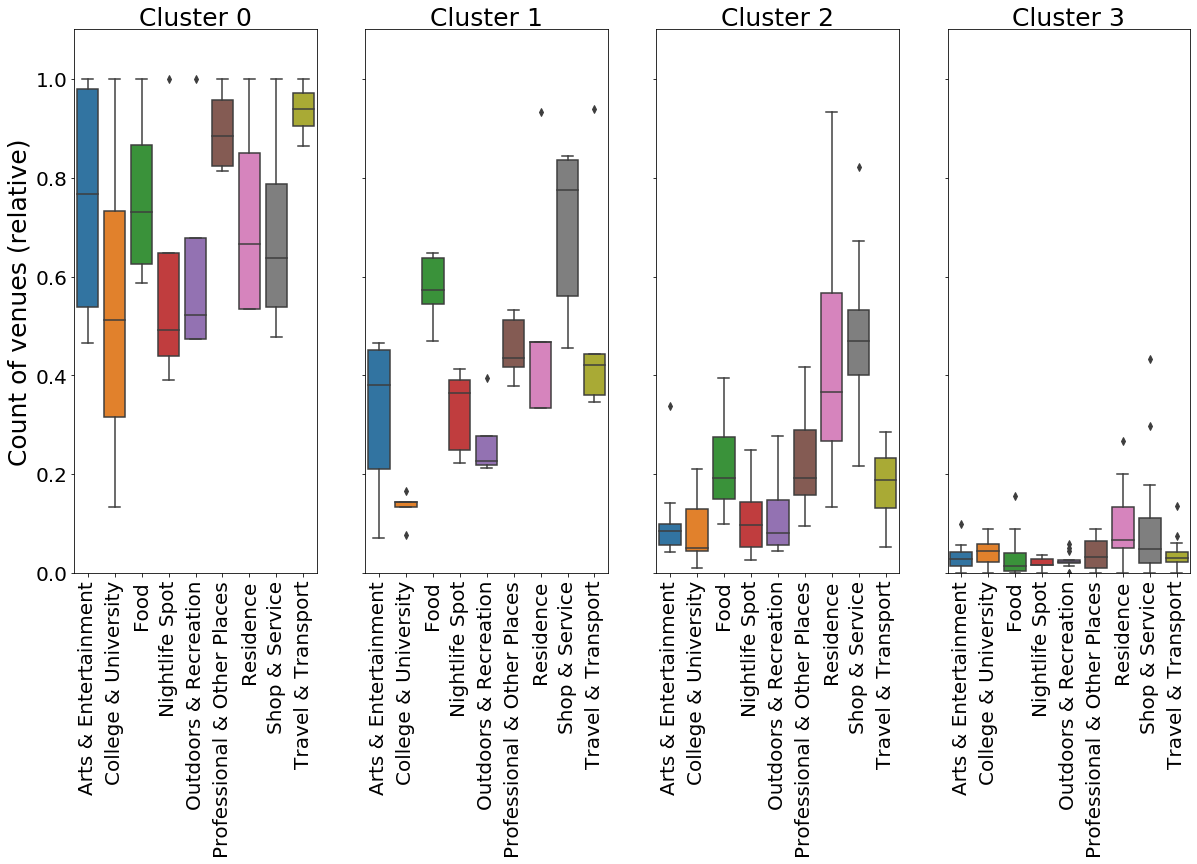

In [36]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = london_venues__clusters_minmax_df[london_venues__clusters_minmax_df['Cluster'] == k].drop(['Cluster','Latitude','Longitude'],1), ax=axes[k])

plt.show()

Map the data

In [41]:
# create map
map_clusters = folium.Map(location=[51.5074, -0.1277], zoom_start=10)

kclusters = kclusters + 1

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_venues__clusters_minmax_df['Latitude'],
                                  london_venues__clusters_minmax_df['Longitude'],
                                  london_venues__clusters_minmax_df['Borough'],
                                  london_venues__clusters_minmax_df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results

Here is how we can characterize the clusters by looking at venue scores:

Cluster 0 (Red) has consistently high scores for all venue categories. This is the most diversely developed part of the city
Cluster 1 (Purple) has highest marks for Shops & Services as well as food.
Cluster 2 (Blue) has high marks in Residence and Shop&Service, indicating these are primarily residential areas.
Cluster 3 (Light blue) has low marks across the board, but also have relatively high marks in Residence and Shop&Service, again indicating these are primarily residential areas, but with fewer (or more disparate) venues.

Plotting the clusters on a map shows us that the clusters can be seen as sort of concentric circles:

Cluster 0 is the oldest central part of the city
Cluster 1 is a little bit further out and to the north
Cluster 2 is a little bit further out again
Cluster 3 boroughs are the furthest from the centre, and probably the prime areas for business and residential development.

# Discussion

To be fair, Foursquare data isn’t all-encompassing. The highest number of venues are in the Food and Shop & Service categories. The data doesn’t take into account a venue’s size (e.g. a university building attracts a lot more people that a hot dog stand – each of them is still one Foursquare “venue”).

# Conclusion

Foursquare data is limited but can provide insights into a city’s development. This data could be combined with other sources (e.g. city data on number of residents) to provide more accurate results.